In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm as scp_norm

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.data import generate_regression_data
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import RegressionDNN
from bbb.models.bnn import RegressionBNN
from bbb.data import load_mnist

### Matplotlib Setup

In [3]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Load Data

In [4]:
train_data = generate_regression_data(train=True, size=1000, batch_size=1000, shuffle=True)
test_data = generate_regression_data(train=False, size=1000, batch_size=1000, shuffle=True)

In [5]:
input_np = test_data.dataset[:][0].detach().numpy().flatten()
output_np = test_data.dataset[:][1].detach().numpy().flatten()

## Helper Classes

In [6]:
ModelDetails = namedtuple('ModelDetails', 'dir mclass')

## Trained Regression Models

In [7]:
MODEL_DETAILS_DICT = {
    # BNN Baseline
    "bnn_baseline_1": ModelDetails("../saved_models/BBB_regression/baseline/2022-03-13-18.27.02", RegressionBNN),
    "bnn_baseline_2": ModelDetails("../saved_models/BBB_regression/baseline/2022-03-13-18.39.36", RegressionBNN),
    # DNN Baseline
    "dnn_baseline_1": ModelDetails("../saved_models/DNN_regression/baseline/2022-03-14-20.33.27", RegressionDNN),
    "dnn_baseline_2": ModelDetails("../saved_models/DNN_regression/baseline/2022-03-14-20.33.55", RegressionDNN),
    # DNN DO Baseline
    "dnn_do_baseline_1": ModelDetails("../saved_models/DNN_regression/dropout/0.5/2022-03-25-14.00.44", RegressionDNN),
    "dnn_do_baseline_2": ModelDetails("../saved_models/DNN_regression/dropout/0.7/2022-03-25-14.05.23", RegressionDNN),
}

## LPD

### BNN

In [8]:
MODEL = "bnn_baseline_2"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    bnn_params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if bnn_params_dict['prior_params']:
    bnn_params_dict['prior_params'] = PriorParameters(**bnn_params_dict['prior_params'])

bnn_params = Parameters(**bnn_params_dict)

bnn_net = MODEL_DETAILS.mclass(params=bnn_params, eval_mode=True)
bnn_net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

2022-03-25 16:11:41,160 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:11:41,160 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:11:41,164 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:11:41,165 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:11:41,166 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:11:41,167 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


<All keys matched successfully>

In [9]:
# bnn_net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])

In [10]:
bnn_pred_mean, bnn_pred_var, _ = bnn_net.predict(test_data.dataset[:][0])
bnn_pred_mean = bnn_pred_mean.detach().numpy().flatten()
bnn_pred_var = bnn_pred_var.detach().numpy().flatten()
bnn_pred_std = np.sqrt(bnn_pred_var)

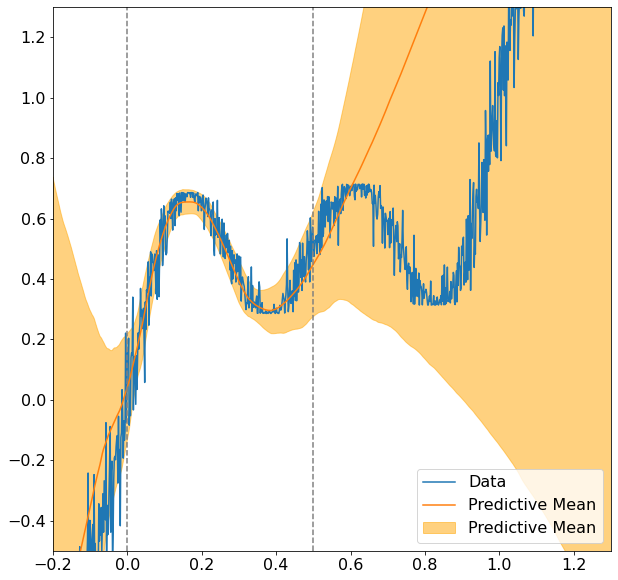

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(input_np, output_np, label='Data')
ax.plot(input_np, bnn_pred_mean, label='Predictive Mean')
ax.fill_between(input_np, bnn_pred_mean-2*bnn_pred_std, bnn_pred_mean+2*bnn_pred_std, label='Predictive Mean', color='orange', alpha=0.5)
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
ax.legend()

In [12]:
bnn_lpd_vals = np.zeros_like(input_np)
for i in range(len(input_np)):
    bnn_lpd_vals[i] = scp_norm(bnn_pred_mean[i], bnn_pred_std[i]).logpdf(output_np[i])
bnn_lpd_vals.mean(), np.exp(bnn_lpd_vals.mean())

(-0.20456137, 0.8150047)

### DNN

In [13]:
MODEL = "dnn_baseline_1"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    dnn_params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if dnn_params_dict['prior_params']:
    dnn_params_dict['prior_params'] = PriorParameters(**dnn_params_dict['prior_params'])

dnn_params = Parameters(**dnn_params_dict)

dnn_net = MODEL_DETAILS.mclass(params=dnn_params, eval_mode=True)
dnn_net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [15]:
# dnn_net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])

In [16]:
dnn_baseline_model_dirs = glob('../saved_models/DNN_regression/baseline/*')
# dnn_baseline_model_dirs

In [17]:
dnn_baseline_preds = np.zeros((len(dnn_baseline_model_dirs), train_data.dataset[:][0].shape[0]))

for i, model in enumerate(dnn_baseline_model_dirs):    
    # Load params
    with open(os.path.join(model, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = RegressionDNN(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(model, 'model.pt'), map_location=torch.device(DEVICE)))

    preds, _, _ = net.predict(test_data.dataset[:][0])
    preds = preds.detach().cpu().numpy().flatten()
    
    dnn_baseline_preds[i, :] = preds

In [18]:
dnn_pred_mean = dnn_baseline_preds.mean(axis=0)
dnn_pred_var = dnn_baseline_preds.var(axis=0)
dnn_pred_std = dnn_baseline_preds.std(axis=0)

dnn_pred_5_quart = np.quantile(dnn_baseline_preds, 0.05, axis=0)
dnn_pred_95_quart = np.quantile(dnn_baseline_preds, 0.95, axis=0)

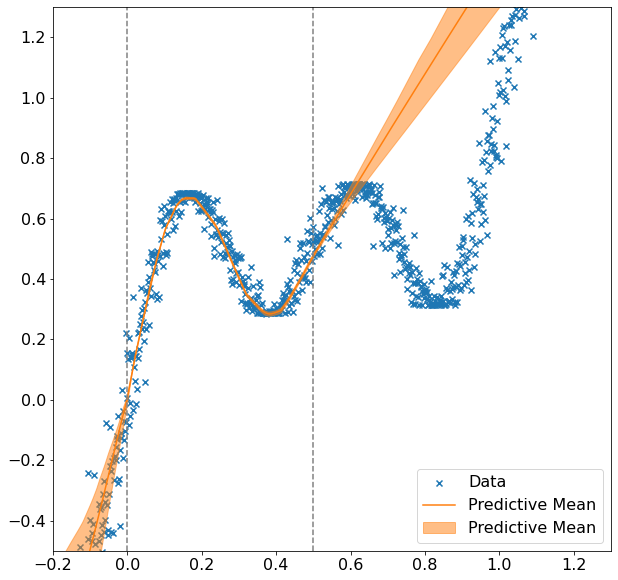

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(input_np, output_np, label='Data', marker='x')
ax.plot(input_np, dnn_pred_mean, label='Predictive Mean', c='tab:orange')
# ax.fill_between(input_np, dnn_pred_mean-2*dnn_pred_std, dnn_pred_mean+2*dnn_pred_std, label='Predictive Mean', color='tab:orange', alpha=0.5)
ax.fill_between(input_np, dnn_pred_5_quart, dnn_pred_95_quart, label='Predictive Mean', color='tab:orange', alpha=0.5)
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
ax.legend()

In [20]:
dnn_lpd_vals = np.zeros_like(input_np)
for i in range(len(input_np)):
    dnn_lpd_vals[i] = scp_norm(dnn_pred_mean[i], dnn_pred_std[i]).logpdf(output_np[i])
dnn_lpd_vals.mean(), np.exp(dnn_lpd_vals.mean())

(-54.052235, 3.3528395e-24)

## Evaluate Multiple Models

In [21]:
# models = ['bnn_baseline_1', 'dnn_baseline_1']
models = ['bnn_baseline_2', 'dnn_do_baseline_2', 'dnn_baseline_2']

2022-03-25 16:12:06,563 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:12:06,563 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:12:06,566 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:12:06,567 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:12:06,568 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 16:12:06,568 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


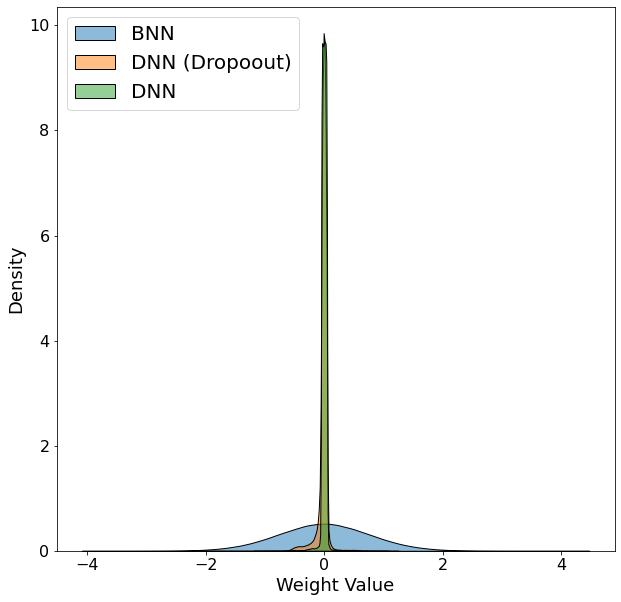

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend(['BNN', 'DNN (Dropoout)', 'DNN'], loc='upper left', prop={'size':20})
plt.savefig(os.path.join("../plots/bbb_regression/baseline/comb_weights_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()